# Project 3 | Classification of Skin Lesions
### Classifying skin lesions using scipy, sklearn and cv2

This notebook contains a step by step process to recreate the results of the report.

A detailed explination of regarding feature extraction and choices of classification model can be found in the report.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import path
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import cv2
from sklearn.preprocessing import StandardScaler
import groupXY_functions as util
import os

# Feature extraction

- load segmenation mask and lesion image
- extract features
- write to csv file

In [3]:
feature_extract = False

In [4]:
#reading groundtruth for the full 2000 pictures 
if feature_extract: dfout = pd.read_csv(path.ground_truth_full)

In [5]:
if feature_extract:
	for index, line in dfout.iterrows():
		# for each image in ground truth, load img, mask
		id_ = line['image_id'] 
		
		img = cv2.imread(path.images_full+f'{id_}.jpg')
		mask = cv2.imread(path.segmentation_full+f'{id_}_segmentation.png',0)

		img, mask = util.scale_image_res(img,mask)
		
		img_plt, mask_plt = plt.imread(path.images_full+f'{id_}.jpg'), plt.imread(path.segmentation_full+f'{id_}_segmentation.png')
		img_plt, mask_plt = util.scale_image_res(img_plt,mask_plt)	
	
		# remove skin from lesion pictures.
		res = cv2.bitwise_and(img,img,mask = mask)
		notmask = cv2.bitwise_not(mask)
		notres = cv2.bitwise_and(img,img,mask = notmask)


		print(f'Running extraction on image {index} out of {dfout.shape[0]} ({index / dfout.shape[0] : 0.2%})', end='\r', flush=True)

		# add feature to dfout
		dfout.at[index, ['color_lesion_r','color_lesion_g','color_lesion_b']] = util.averageColorsSimple(res)

		dfout.at[index, ['color_skin_r','color_skin_g','color_skin_b']] = util.averageColorsSimple(notres)

		dfout.at[index, ['area','perimeter']] = util.measure_area_perimeter(mask)

		dfout.at[index, ['min_symmetry', 'avg_symmetry']] = util.all_deg(mask)

		# dfout.at[index, ['border_dark', 'border_skin']] = util.boundry_check2(img_plt,mask_plt)

		dfout.at[index, ['color_variance']] = util.color_variance(img_plt, mask_plt)

In [6]:
if feature_extract:
    save_path = path.out+'out_rescaled.csv'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    dfout.to_csv(save_path)

In [7]:
df = pd.read_csv(path.out+'out_rescaled.csv', index_col=0)
df.drop(['seborrheic_keratosis'], axis=1, inplace=True)
df.set_index('image_id', inplace = True)
df

,melanoma,color_lesion_r,color_lesion_g,color_lesion_b,color_skin_r,color_skin_g,color_skin_b,area,perimeter,min_symmetry,avg_symmetry,color_variance
image_id,,,,,,,,,,,,
ISIC_0000000,0.0,39.054190,36.538438,40.255583,131.778399,112.052640,91.833945,93199950.0,92836720.0,16029.0,7.049952e+04,151.360497
ISIC_0000001,0.0,2.845744,3.609158,5.347413,162.981837,158.673963,161.133578,13683300.0,13630556.0,2767.0,4.245661e+03,80.006250
ISIC_0000002,1.0,33.629795,32.640172,39.234969,154.099134,118.378237,97.091812,60678015.0,60442135.0,12255.0,2.758868e+04,111.763142
ISIC_0000003,0.0,23.266308,31.746686,44.736262,145.226959,144.897696,145.935318,66636855.0,66377384.0,15177.0,2.240491e+04,133.195345
ISIC_0000004,1.0,52.905618,43.803538,64.394117,27.534957,25.022511,26.508849,68880345.0,68611974.0,5921.0,3.635539e+04,137.091211
...,...,...,...,...,...,...,...,...,...,...,...,...
ISIC_0015220,0.0,35.906329,43.317209,102.319993,31.248853,32.884912,56.015390,146078280.0,145508436.0,146078280.0,1.460783e+08,77.162167
ISIC_0015233,0.0,15.658445,20.133662,29.912802,90.463575,110.652808,163.966020,49971585.0,49777107.0,13782.0,2.372966e+04,143.687160
ISIC_0015260,0.0,6.732133,10.198769,16.232717,133.427841,148.020522,169.899677,40330800.0,40174553.0,11523.0,3.770876e+04,130.847239


## Note
Min and avg symmetry is based on amount of pixels that dont overlap at different rotations. To account for different sizes of masks we devide by the area to standardize the scores and give a procent of the masks that dont overlap when folded.

In [8]:
# Standardize symmetry 
df['std_min_symmetry'] = df['min_symmetry'] / (df['area'] / 255)
df['std_avg_symmetry'] = df['avg_symmetry'] / (df['area'] / 255)

# Due to how we deal with masks hiiting border their area was taken based on sum of pixels with value 255.
# So here we correct by setting all values of 255 to 1 as it would be since area / area = 1
df.loc[ df['std_min_symmetry'] > 254, 'std_min_symmetry'] = 1
df.loc[ df['std_avg_symmetry'] > 254, 'std_avg_symmetry'] = 1


To capture some of the irregularities in the border we added the formula for circularity

In [9]:
df['circularity'] = (4*np.pi*df['area'])/(df['perimeter'])**2

In [10]:
df.drop(['min_symmetry', 'avg_symmetry', 'area', 'perimeter', 'color_lesion_b', 'color_lesion_g', 'color_skin_g', 'color_skin_b'], axis=1, inplace=True)

Scaled with standard scalar

In [11]:
#scaling features with standardscalar
featureDf = df.drop(['melanoma'], axis=1)
#logfeature = np.log(featureDf)

scalar = StandardScaler().fit(featureDf)

In [12]:
scaled_features = scalar.transform(featureDf)

In [13]:
#combining scaled df with our Y values
scaled_features_df = pd.DataFrame(scaled_features, index=featureDf.index, columns=featureDf.columns)
finalDf = pd.concat([scaled_features_df, df['melanoma']], axis = 1)

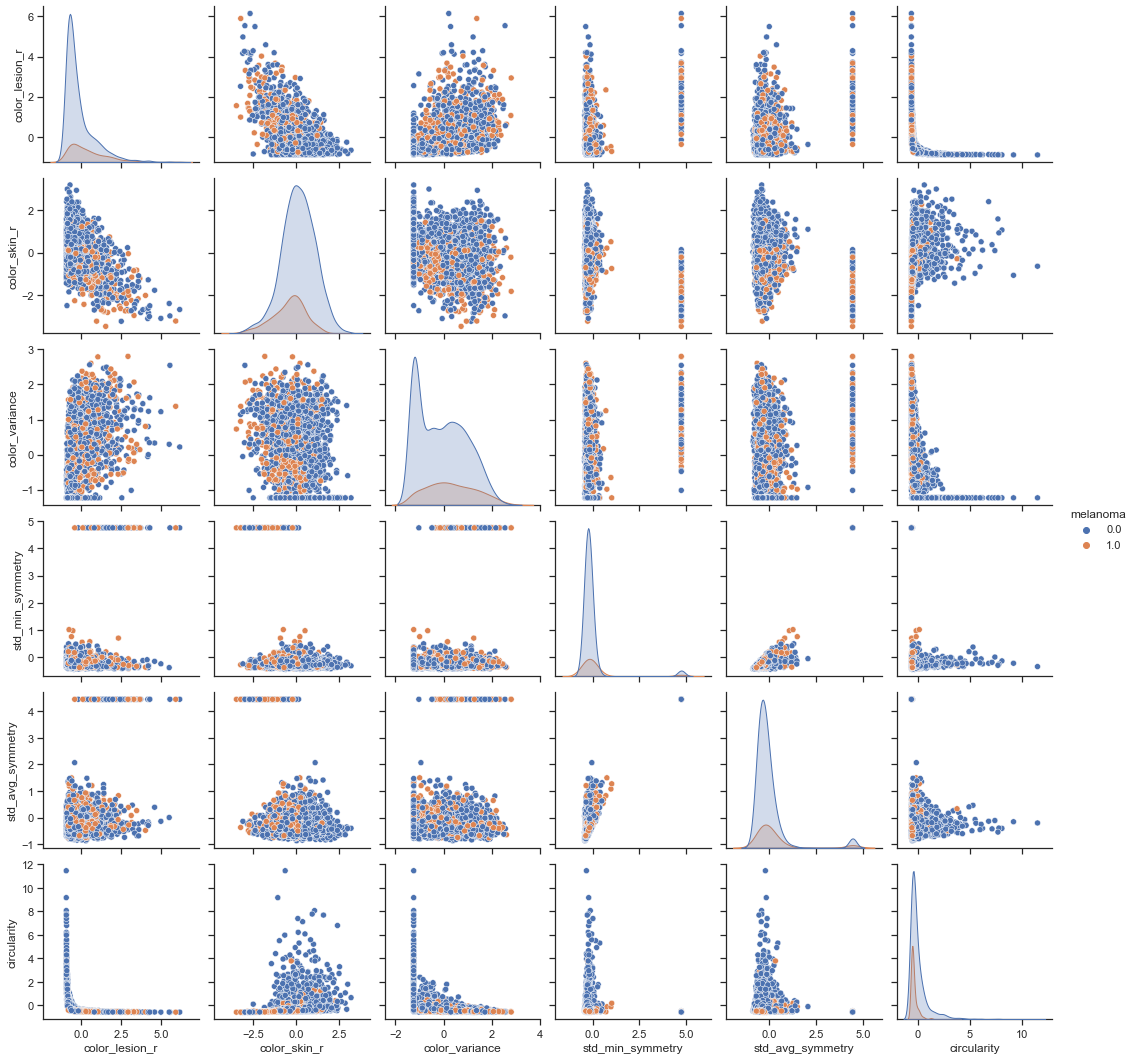

In [22]:
colors = {0:'tab:blue', 1:'tab:red'}
sns.pairplot(finalDf, hue='melanoma')

/Users/alexandernielsen/opt/anaconda3/envs/cnn/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/alexandernielsen/opt/anaconda3/envs/cnn/lib/python3.7/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/alexandernielsen/opt/anaconda3/envs/cnn/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for k

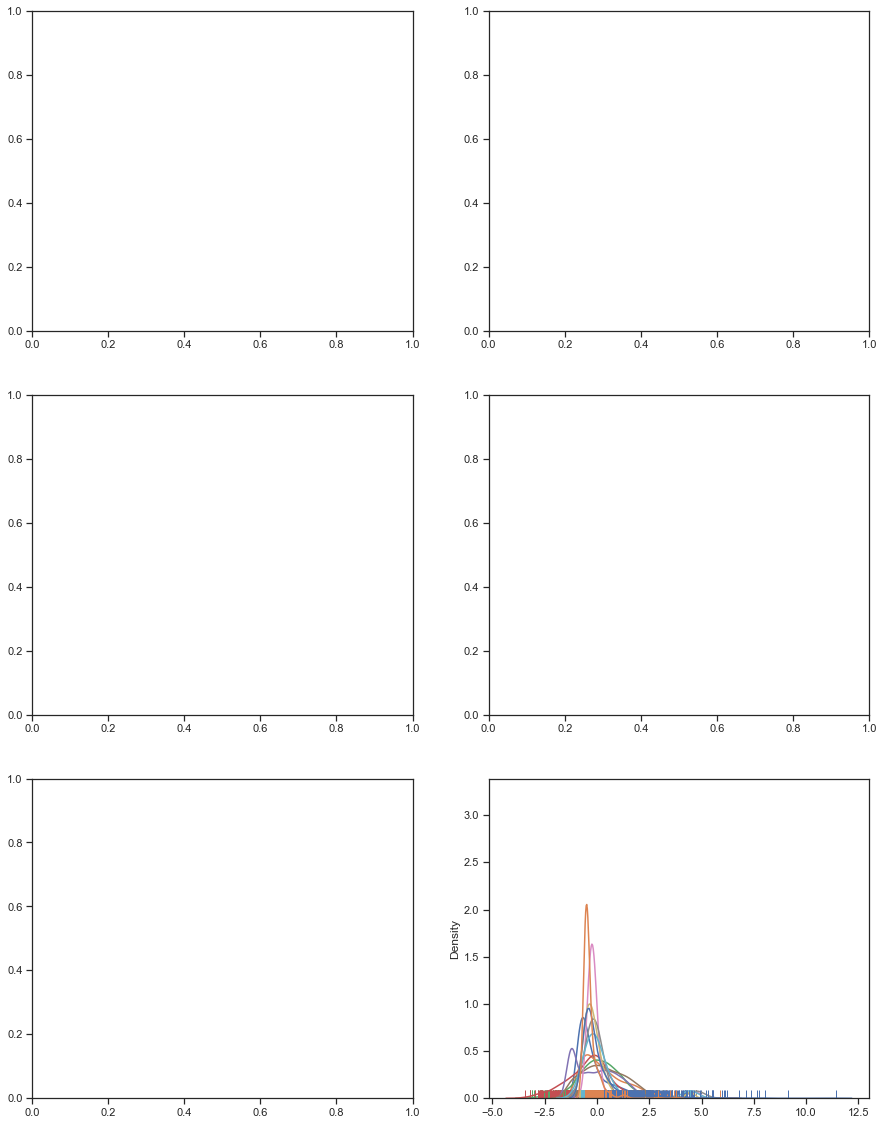

In [28]:
target_0 = finalDf.loc[finalDf['melanoma'] == 0]
target_1 = finalDf.loc[finalDf['melanoma'] == 1]

fig, axes = plt.subplots(3, 2, figsize=(15, 20))
for index, variable in enumerate(featureDf.columns):
    sns.distplot(target_0[[variable]], hist=False, rug=True, ax = axes[index // 2, index % 3])
    sns.distplot(target_1[[variable]], hist=False, rug=True)

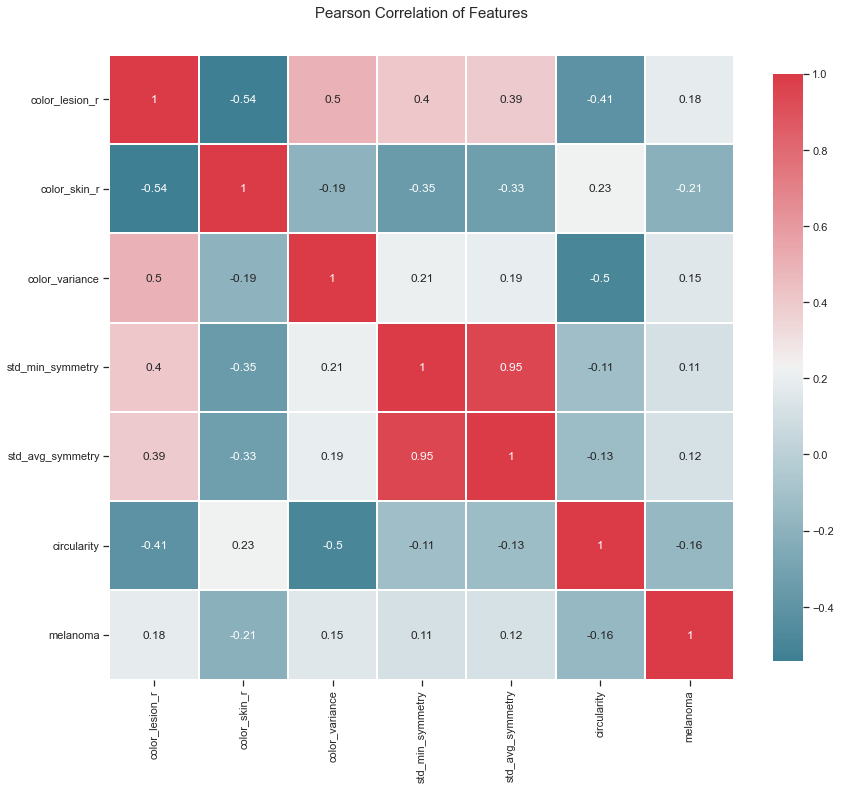

In [15]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(finalDf)

In [14]:
from itertools import combinations
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

df2=finalDf

X = df2.drop(['melanoma'], axis=1,)

Y = df2['melanoma']

# features = list(X.columns)

# k = 3
# best_auc = 0

# for i in range(2, 7):
#     print(i)
#     for comb in tqdm(combinations(features, i)):
#         inner_auc = []
#         inner_acc = []
#         for j in range(500):
#             X_dev, X_test, y_dev, y_test = train_test_split(
#                     X[list(comb)], y, stratify=y)

#             X_train, X_val, y_train, y_val = train_test_split(
#                     X_dev, y_dev, stratify=y_dev)

#             knn = KNeighborsClassifier(n_neighbors=k) # other hyperparameters possible
#             knntrained = knn.fit(X_train, y_train)

#             y_val_knn = knntrained.predict(X_val)

#             acc_knn = accuracy_score(y_val, y_val_knn)
#             auc_knn = roc_auc_score(y_val, y_val_knn)

#             inner_auc.append(auc_knn)
#             inner_acc.append(acc_knn)
        
#         inner_auc = [1 - thing if thing < 0.5 else thing for thing in inner_auc]
#         mean_auc = np.mean(inner_auc)
#         mean_acc = np.mean(inner_acc)

#         if mean_auc > best_auc:
#             best_auc = mean_auc
#             best_acc = mean_acc
#             best_comb = comb

In [15]:
# Split dataset to development and test set
X_dev, X_test, y_dev, y_test = train_test_split(
        X[['color_variance', 'std_avg_symmetry']], Y, stratify=Y, test_size=0.2, random_state=180)

# Split development set to training and valuation sets

X_train, X_val, y_train, y_val = train_test_split(
       X_dev, y_dev, stratify=y_dev, random_state=180)

In [16]:
# auc_list = [1 - thing if thing < 0.5 else thing for thing in auc_list]
# np.mean(auc_list)

In [17]:
# Train a classifiers
knn = KNeighborsClassifier(n_neighbors=5)
knntrained = knn.fit(X_train, y_train)

dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)

y_val_tree = dtree.predict(X_val)
y_val_knn = knntrained.predict(X_val)

from sklearn.model_selection import cross_val_score
scores_knn = cross_val_score(knntrained, X_val, y_val, cv=6)
scores_tree = cross_val_score(dtree, X_val, y_val, cv=6)

auc_knn = roc_auc_score(y_val, y_val_knn)
auc_tree = roc_auc_score(y_val, y_val_tree)

print(f'KNN: \nAccuracy: {np.mean(scores_knn)}  AUC_ROC: {auc_knn} \n')
print(f'Tree: \nAccuracy: {np.mean(scores_tree)}  AUC_ROC: {auc_tree}')

KNN: 
Accuracy: 0.8051409618573797  AUC_ROC: 0.5302564102564102 

Tree: 
Accuracy: 0.7124604251469923  AUC_ROC: 0.5087179487179487


In [18]:
# ONLY FOR REPORTING, also evaluate on test set
X_test = X_test

y_test_knn = knntrained.predict(X_test)
y_test_tree = dtree.predict(X_test)

auc_test = roc_auc_score(y_test, y_test_knn)
auc_test_tree = roc_auc_score(y_test, y_test_tree)

print(auc_test)
print(auc_test_tree)

# For small datasets these results will depend on the random seed you chose when splitting, 
# this is why it is good to look at multiple splits/cross-validation

0.5328205128205128
0.5087179487179487


In [19]:
import pickle
with open('pickle_knn.pickle','wb') as pickle_out:
    pickle.dump(knntrained,pickle_out)

with open('pickle_scalar.pickle','wb') as scalar_out:
    pickle.dump(scalar,scalar_out)